In [120]:
a = MyPerformanceChecker()

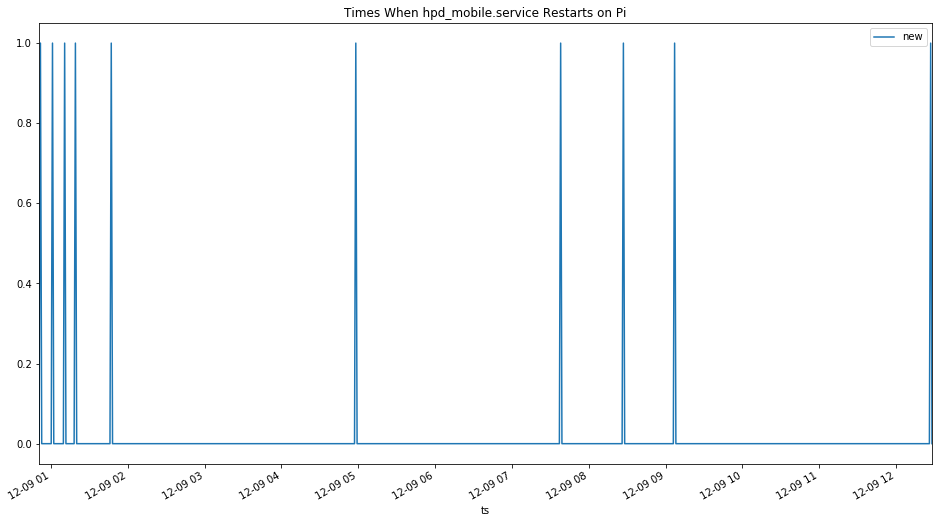

In [180]:
# Show when the service restarted
a.start_line_frames.plot(title='Times When hpd_mobile.service Restarts on Pi')

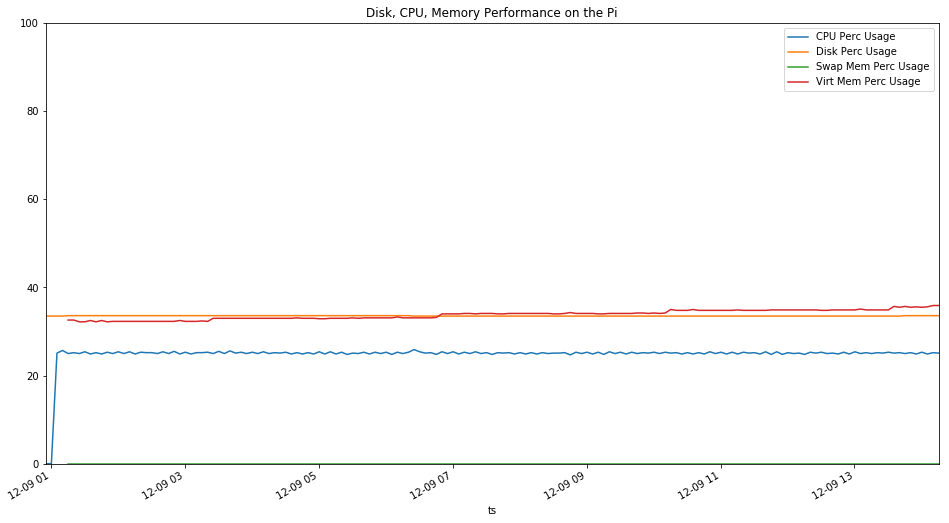

In [177]:
# Show the Disk, CPU, Memory Performance
a.cpu_frames.plot(title='Disk, CPU, Memory Performance on the Pi', ylim=[0, 100])

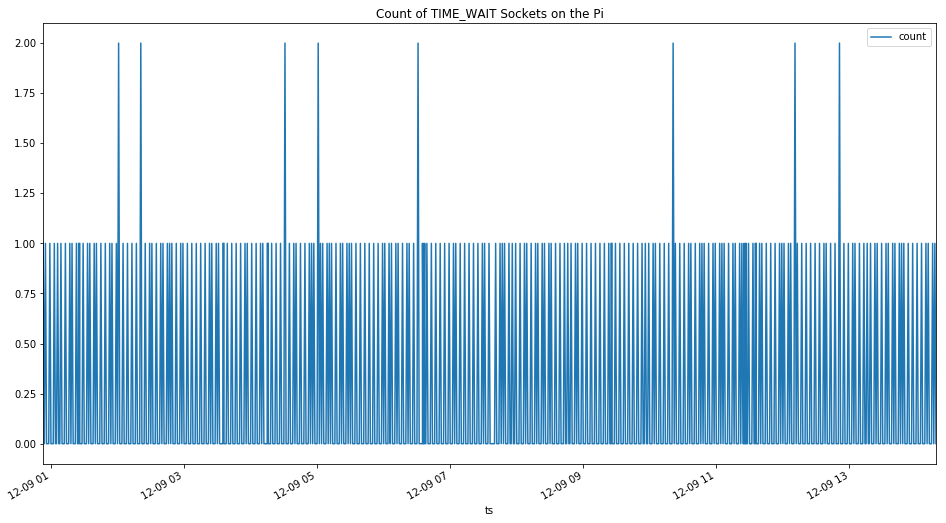

In [178]:
# Show a count of the TIME_WAIT sockets on the pi throughout the runtime
a.time_wait_frames.plot(title='Count of TIME_WAIT Sockets on the Pi')

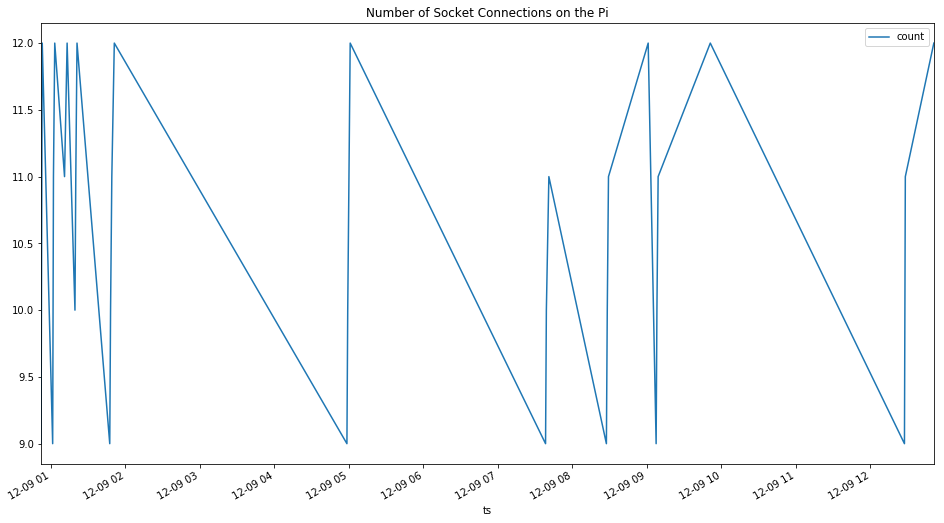

In [179]:
# Show the Number of socket connections to the pi
a.conn_frames.plot(title="Number of Socket Connections on the Pi")

In [164]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 9]

class MyPerformanceChecker():
    """
    Only configuration required is where the sensors_logfile.log is located
    """
    def __init__(self, logfile_to_read = '/Volumes/HPD_Mobile/test10/BS2/sensors_logfile.log'):
        self.read_logfile(logfile_to_read)
        self.process_performance()
        self.find_new_starts()
        self.find_time_waits()
        self.find_conns()
        
    def read_logfile(self, path):
        with open(path, 'r') as f:
            self.logfile = f.read().splitlines()
    
    def process_performance(self):
        self.cpu_lines = [x for x in self.logfile if "CPU Perc Usage" in x]
        my_list = []
        for line in self.cpu_lines:
            spl = line.split(',')
            dt_unform = spl[0]
            dt = datetime.strptime(dt_unform, '%d-%m-%Y:%H:%M:%S')
            d = {'ts': dt}
            info = spl[1].split('] ')[1].split('\t')
            for l in info:
                my_k = l.split(': ')[0]
                my_v = float(l.split(': ')[1])
                d[my_k] = my_v
            my_list.append(d)  
        self.cpu_frames = pd.DataFrame(my_list).set_index('ts')
        to_drop = ['Swap Mem Available', 'Virt Mem Available']
        for d in to_drop:
            try:
                self.cpu_frames.drop(d, inplace=True, axis = 1)
            except:
                continue
        
    def find_new_starts(self):
        # To show where new starts occur.  The time of occurance corresponds to '1'
        self.start_line_inds = [i for i, e in enumerate(self.logfile) if "NEW START" in e]
        my_list = []
        for ind in self.start_line_inds:
            dt_next = ind + 1
            dt_unform = self.logfile[ind + 1].split(',')[0]
            dt = datetime.strptime(dt_unform, '%d-%m-%Y:%H:%M:%S')
            dt_prev = dt - timedelta(minutes = 1)
            dt_foll = dt + timedelta(minutes = 1)
            prev = {'ts': dt_prev, 'new': 0}
            cur = {'ts': dt, 'new': 1}
            foll = {'ts': dt_foll, 'new': 0}
            my_list.append(prev)
            my_list.append(cur)
            my_list.append(foll)
        self.start_line_frames = pd.DataFrame(my_list).set_index('ts')
        
    def find_time_waits(self):
        # To show where TIME_WAIT sockets are found.  This makes the assumption that the following
        # minute does not have a TIME_WAIT socket, but this may be irrelevant
        self.time_wait_lines = [x for x in self.logfile if "Number of sockets in TIME_WAIT" in x]
        my_list = []
        for line in self.time_wait_lines:
            spl = line.split(',')
            dt_unform = spl[0]
            dt = datetime.strptime(dt_unform, '%d-%m-%Y:%H:%M:%S')
            count = spl[1].split('TIME_WAIT: ')[1]
            cur = {'ts': dt, 'count': int(count)}
            dt_foll = dt + timedelta(minutes = 1)
            foll = {'ts': dt_foll, 'count': 0}
            if len(my_list) > 0:
                if (dt - my_list[-1]['ts']).seconds > 60:
                    dt_prev = dt - timedelta(minutes = 1)
                    prev = {'ts': dt_prev, 'count': 0}
                    my_list.append(prev)
                    my_list.append(cur)
                    my_list.append(foll)
            else:
                my_list.append(cur)
                my_list.append(foll)
        self.time_wait_frames = pd.DataFrame(my_list).set_index('ts')
    
    def find_conns(self):
        self.conn_lines = [x for x in self.logfile if "Number of connections has increased" in x
                                or "Number of base connections" in x]
        my_list = []
        for line in self.conn_lines:
            spl = line.split(',')
            dt_unform = spl[0]
            dt = datetime.strptime(dt_unform, '%d-%m-%Y:%H:%M:%S')
            count = spl[1].split(': ')[1]
            cur = {'ts': dt, 'count': int(count)}
            my_list.append(cur)
        self.conn_frames = pd.DataFrame(my_list).set_index('ts')